# Experimenting with the Number of Layers
In this experiment, we will explore how varying the number of layers in a neural network affects its performance on a given task. We will use a simple feedforward neural network architecture and train it on a standard dataset, such as MNIST or CIFAR-10.

## Methodology
1. **Dataset Selection**: Dataset from Kaggle: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset.
2. **Model Architecture**: Define a feedforward neural network with a variable number of layers.
3. **Training**: Train the model on the selected dataset.
4. **Evaluation**: Evaluate the model's performance using appropriate metrics (e.g., accuracy, loss).
5. **Analysis**: Analyze how the number of layers impacts performance.


In [1]:
## Data download:
import dask.dataframe as dd
csv_path = './healthcare-dataset-stroke-data.csv'

# Dask may mis-infer integer columns when some partitions contain missing values.
# Two common fixes are:
#  1) pass assume_missing=True to treat unspecified integer columns as floats, or
#  2) provide explicit dtypes for troublesome columns (e.g. {'age': 'float64'}).
# We'll try a robust approach: read with assume_missing=True and fall back to an explicit dtype if needed.
try:
    data = dd.read_csv(csv_path, assume_missing=True)
except Exception as e:
    print('dd.read_csv failed:', e)
    print('Retrying with explicit dtype for age as float64')
    data = dd.read_csv(csv_path, dtype={'age': 'float64'}, assume_missing=True)

# Preview the data
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046.0,Male,67.0,0.0,1.0,Yes,Private,Urban,228.69,36.6,formerly smoked,1.0
1,51676.0,Female,61.0,0.0,0.0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1.0
2,31112.0,Male,80.0,0.0,1.0,Yes,Private,Rural,105.92,32.5,never smoked,1.0
3,60182.0,Female,49.0,0.0,0.0,Yes,Private,Urban,171.23,34.4,smokes,1.0
4,1665.0,Female,79.0,1.0,0.0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1.0


Data needs to be cleaned to numerical values only, and some columns are categorical and not binary. We will use pandas get_dummies to convert categorical columns to binary columns.

In [2]:
## Data cleaning:
data = data.compute()
data = dd.from_pandas(data, npartitions=4)
data = data.categorize()
data = dd.get_dummies(data, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'], drop_first=True)
data = data.dropna()
data = data.compute()

# Preview the cleaned data
data.head()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046.0,67.0,0.0,1.0,228.69,36.6,1.0,True,False,True,False,True,False,False,True,True,False,False
2,31112.0,80.0,0.0,1.0,105.92,32.5,1.0,True,False,True,False,True,False,False,False,False,True,False
3,60182.0,49.0,0.0,0.0,171.23,34.4,1.0,False,False,True,False,True,False,False,True,False,False,True
4,1665.0,79.0,1.0,0.0,174.12,24.0,1.0,False,False,True,False,False,True,False,False,False,True,False
5,56669.0,81.0,0.0,0.0,186.21,29.0,1.0,True,False,True,False,True,False,False,True,True,False,False


In [3]:
# Model architecture definition
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

input_shape = data.shape[1] - 1  # Exclude target variable

def create_model(num_layers, input_shape):
    model = keras.Sequential()
    model.add(layers.Input(shape=input_shape))
    for _ in range(num_layers):
        model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

2025-11-08 11:39:16.876826: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Quick minimal test of model creation function
model = create_model(num_layers=3, input_shape=input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1152      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9537 (37.25 KB)
Trainable params: 9537 (37.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [5]:
# Separating data into test and train sets
from sklearn.model_selection import train_test_split
X = data.drop('stroke', axis=1)
y = data['stroke']

# Splitting the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalizing the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [8]:
# Training and results helper functions
def compile_and_train_model(model, X_train, y_train, X_val, y_val, epochs=10, batch_size=32):
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=epochs,
                        batch_size=batch_size)
    return model, history

def evaluate_model(model, X_test, y_test):
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')
    return test_loss, test_accuracy


In [9]:
# Simple example up to evaluating the model
model = create_model(num_layers=3, input_shape=input_shape)
model, history = compile_and_train_model(model, X_train, y_train, X_val, y_val, epochs=10)
test_loss, test_accuracy = evaluate_model(model, X_test, y_test)

Epoch 1/10
123/123 [==============================] - 3s 9ms/step - loss: 0.1897 - accuracy: 0.9585 - val_loss: 0.1663 - val_accuracy: 0.9532
Epoch 2/10
123/123 [==============================] - 1s 4ms/step - loss: 0.1420 - accuracy: 0.9603 - val_loss: 0.1783 - val_accuracy: 0.9532
Epoch 3/10
123/123 [==============================] - 1s 5ms/step - loss: 0.1335 - accuracy: 0.9603 - val_loss: 0.1671 - val_accuracy: 0.9532
Epoch 4/10
123/123 [==============================] - 1s 5ms/step - loss: 0.1283 - accuracy: 0.9603 - val_loss: 0.1683 - val_accuracy: 0.9532
Epoch 5/10
123/123 [==============================] - 1s 7ms/step - loss: 0.1259 - accuracy: 0.9603 - val_loss: 0.1678 - val_accuracy: 0.9532
Epoch 6/10
123/123 [==============================] - 1s 9ms/step - loss: 0.1208 - accuracy: 0.9603 - val_loss: 0.1807 - val_accuracy: 0.9532
Epoch 7/10
123/123 [==============================] - 1s 5ms/step - loss: 0.1203 - accuracy: 0.9605 - val_loss: 0.1777 - val_accuracy: 0.9532
Epoch 

## Model evaluation results
We will record the performance metrics for each configuration of the neural network (i.e., different numbers of layers) and analyze the results to determine the optimal architecture for our research question.

In [10]:
# Looping through different numbers of layers
layer_options = range(1, 6)  # Testing from 1 to 5 layers
results = {}

for num_layers in layer_options:
    print(f'\nTraining model with {num_layers} layers')
    model = create_model(num_layers=num_layers, input_shape=input_shape)
    model, history = compile_and_train_model(model, X_train, y_train, X_val, y_val, epochs=10)
    test_loss, test_accuracy = evaluate_model(model, X_test, y_test)
    results[num_layers] = {'test_loss': test_loss, 'test_accuracy': test_accuracy}

# Model evaluation results
for num_layers, metrics in results.items():
    print(f'Layers: {num_layers}, Test Loss: {metrics["test_loss"]}, Test Accuracy: {metrics["test_accuracy"]}')



Training model with 1 layers
Epoch 1/10
123/123 [==============================] - 2s 9ms/step - loss: 0.4091 - accuracy: 0.8449 - val_loss: 0.2085 - val_accuracy: 0.9532
Epoch 2/10
123/123 [==============================] - 1s 5ms/step - loss: 0.1705 - accuracy: 0.9603 - val_loss: 0.1686 - val_accuracy: 0.9532
Epoch 3/10
123/123 [==============================] - 1s 9ms/step - loss: 0.1480 - accuracy: 0.9603 - val_loss: 0.1625 - val_accuracy: 0.9532
Epoch 4/10
123/123 [==============================] - 1s 5ms/step - loss: 0.1413 - accuracy: 0.9598 - val_loss: 0.1618 - val_accuracy: 0.9532
Epoch 5/10
123/123 [==============================] - 1s 4ms/step - loss: 0.1377 - accuracy: 0.9603 - val_loss: 0.1621 - val_accuracy: 0.9532
Epoch 6/10
123/123 [==============================] - 0s 4ms/step - loss: 0.1352 - accuracy: 0.9603 - val_loss: 0.1622 - val_accuracy: 0.9532
Epoch 7/10
123/123 [==============================] - 1s 4ms/step - loss: 0.1335 - accuracy: 0.9600 - val_loss: 0.1623

## Results and Discussion
The results of the experiments will be presented in tabular and graphical formats, highlighting the relationship between the number of layers and model performance. We will discuss the implications of our findings and provide recommendations for future research directions in neural network architecture design.

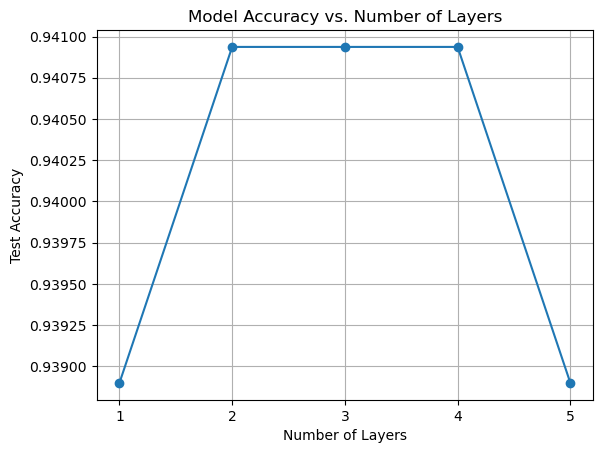

In [11]:
# Plotting results
import matplotlib.pyplot as plt
layer_counts = list(results.keys())
accuracies = [results[num_layers]['test_accuracy'] for num_layers in layer_counts]
plt.plot(layer_counts, accuracies, marker='o')
plt.title('Model Accuracy vs. Number of Layers')
plt.xlabel('Number of Layers')
plt.ylabel('Test Accuracy')
plt.xticks(layer_counts)
plt.grid()
plt.show()


## Results and Discussion:
In observing the accuracy of the models, it seems that there is no further benefit to adding more layers after adding 2 hidden layers. The accuracy appears to plateau around 94% at 2 layers and persist until 4 layers, after which it decreases.

